# Día 3 — Redes Neuronales para SISRED

## Objetivos
1. Entender una red neuronal como una función entrenable (pesos + sesgo + activación).
2. Implementar una "neurona" para aprender una relación no lineal
3. Construir un mini-clasificador de texto (MLP) para categorizar documentos tipo SISRED.

# Parte A — PyTorch: cuando el problema NO es lineal
## Caso SISRED: tiempo de procesamiento de documentos (OCR + extracción + validación)

### Idea
En sistemas documentales (SISRED/BCN), el tiempo de procesamiento no siempre crece linealmente:
- hasta cierto volumen: casi lineal
- luego: colas, I/O, revisión manual, reintentos → crecimiento no lineal

### Objetivo del ejercicio
1) Probar un modelo lineal (1 neurona) y ver su limitación.
2) Usar un MLP simple para capturar no linealidad.
3) Ver gráficamente la diferencia: datos vs función aprendida.


In [66]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

## Dataset (simulado, realista y NO lineal)

**Entrada:** páginas del documento (o tamaño de lote)  
**Salida:** minutos de procesamiento (OCR + extracción + validación)

Modelo conceptual:
- Base lineal: a * páginas + b
- Penalización no lineal cuando el documento es grande:
  - revisión adicional
  - más errores OCR
  - más I/O
  - más validación

Esto genera una curva: lineal al inicio, luego más empinada.


In [67]:
def true_time(pages):
    # componente base (lineal)
    a, b = 0.18, 2.0  # min/página + setup
    base = a * pages + b
    
    # penalización no lineal: crece fuerte a partir de ~60 páginas
    # (simula cuellos de botella / revisión manual)
    penalty = 0.015 * np.maximum(pages - 60, 0)**2
    
    return base + penalty

N = 260
pages = np.random.randint(1, 140, size=N).astype(np.float32)
noise = np.random.normal(0, 1.2, size=N).astype(np.float32)  # ruido
minutes = true_time(pages) + noise

# train/val split
idx = np.random.permutation(N)
train_size = int(0.8 * N)
train_idx, val_idx = idx[:train_size], idx[train_size:]

pages_train, y_train_np = pages[train_idx], minutes[train_idx]
pages_val,   y_val_np   = pages[val_idx],   minutes[val_idx]

X_train = torch.tensor(pages_train).unsqueeze(1).to(device)
y_train = torch.tensor(y_train_np).unsqueeze(1).to(device)

X_val = torch.tensor(pages_val).unsqueeze(1).to(device)
y_val = torch.tensor(y_val_np).unsqueeze(1).to(device)

X_train.shape, y_train.shape


(torch.Size([208, 1]), torch.Size([208, 1]))

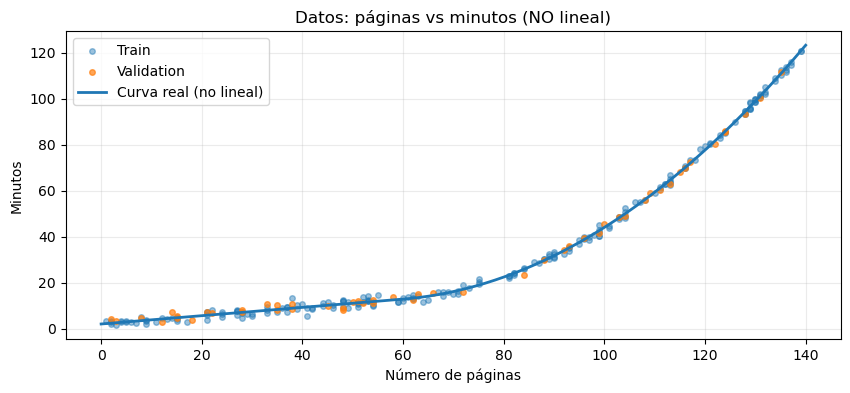

In [68]:
x_grid = np.linspace(0, 140, 300, dtype=np.float32)
y_grid = true_time(x_grid)

plt.figure(figsize=(10,4))
plt.scatter(pages_train, y_train_np, s=16, alpha=0.45, label="Train")
plt.scatter(pages_val, y_val_np, s=16, alpha=0.70, label="Validation")
plt.plot(x_grid, y_grid, linewidth=2, label="Curva real (no lineal)")
plt.title("Datos: páginas vs minutos (NO lineal)")
plt.xlabel("Número de páginas")
plt.ylabel("Minutos")
plt.grid(True, alpha=0.25)
plt.legend()
plt.show()


## Modelo 1 — 1 neurona lineal (baseline)

Este modelo solo puede aprender:

$\hat{y} = w x + b$


Si los datos son curvos, el modelo lineal hará lo mejor posible…
pero no puede representar la curva completa.


In [69]:
class LinearNeuron(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)
    def forward(self, x):
        return self.linear(x)

lin_model = LinearNeuron().to(device)
criterion = nn.MSELoss()
lin_opt = optim.Adam(lin_model.parameters(), lr=0.05)

lin_hist = {"train": [], "val": []}

for epoch in range(1, 801):
    lin_model.train()
    lin_opt.zero_grad()
    pred = lin_model(X_train)
    loss = criterion(pred, y_train)
    loss.backward()
    lin_opt.step()

    lin_model.eval()
    with torch.no_grad():
        vpred = lin_model(X_val)
        vloss = criterion(vpred, y_val)

    lin_hist["train"].append(loss.item())
    lin_hist["val"].append(vloss.item())

    if epoch % 60 == 0:
        print(f"[Linear] Epoch {epoch:3d} | train {loss.item():.3f} | val {vloss.item():.3f}")


[Linear] Epoch  60 | train 306.968 | val 209.442
[Linear] Epoch 120 | train 286.377 | val 190.809
[Linear] Epoch 180 | train 268.578 | val 177.356
[Linear] Epoch 240 | train 254.072 | val 167.208
[Linear] Epoch 300 | train 242.662 | val 160.076
[Linear] Epoch 360 | train 233.948 | val 155.456
[Linear] Epoch 420 | train 227.481 | val 152.814
[Linear] Epoch 480 | train 222.816 | val 151.645
[Linear] Epoch 540 | train 219.550 | val 151.502
[Linear] Epoch 600 | train 217.332 | val 152.015
[Linear] Epoch 660 | train 215.873 | val 152.891
[Linear] Epoch 720 | train 214.944 | val 153.917
[Linear] Epoch 780 | train 214.372 | val 154.947


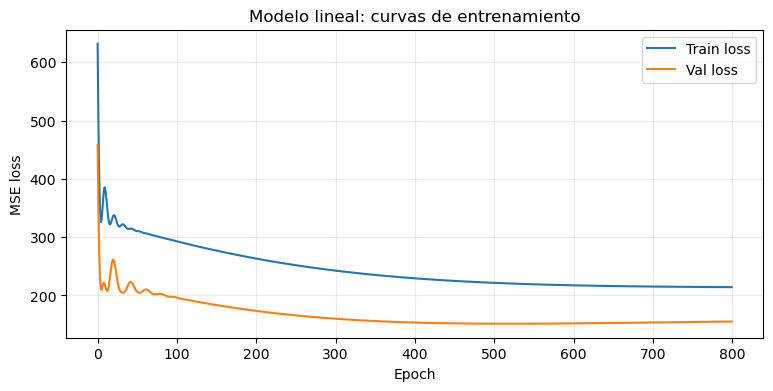

In [70]:
plt.figure(figsize=(9,4))
plt.plot(lin_hist["train"], label="Train loss")
plt.plot(lin_hist["val"], label="Val loss")
plt.title("Modelo lineal: curvas de entrenamiento")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.grid(True, alpha=0.25)
plt.legend()
plt.show()


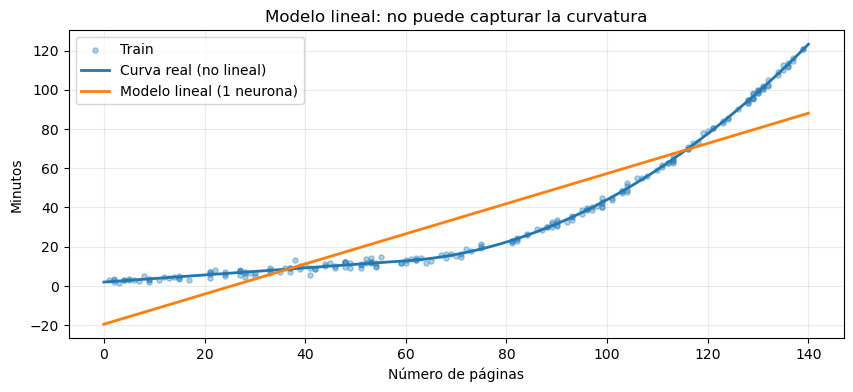

In [71]:
lin_model.eval()
with torch.no_grad():
    X_line = torch.tensor(x_grid).unsqueeze(1).to(device)
    y_lin = lin_model(X_line).cpu().numpy().flatten()

plt.figure(figsize=(10,4))
plt.scatter(pages_train, y_train_np, s=14, alpha=0.35, label="Train")
plt.plot(x_grid, y_grid, linewidth=2, label="Curva real (no lineal)")
plt.plot(x_grid, y_lin, linewidth=2, label="Modelo lineal (1 neurona)")
plt.title("Modelo lineal: no puede capturar la curvatura")
plt.xlabel("Número de páginas")
plt.ylabel("Minutos")
plt.grid(True, alpha=0.25)
plt.legend()
plt.show()


## Modelo 2 — MLP (Feedforward) para capturar no linealidad

Ahora usamos un MLP pequeño:
- Linear(1→32) + ReLU
- Linear(32→32) + ReLU
- Linear(32→1)

Esto ya puede aproximar funciones curvas.


In [ ]:
class SmallMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 320),
            nn.ReLU(),
            nn.Linear(320, 320),
            nn.ReLU(),
            nn.Linear(320, 1)
        )
    def forward(self, x):
        return self.net(x)

mlp_model = SmallMLP().to(device)
mlp_opt = optim.Adam(mlp_model.parameters(), lr=0.01)

mlp_hist = {"train": [], "val": []}

for epoch in range(1, 501):
    mlp_model.train()
    mlp_opt.zero_grad()
    pred = mlp_model(X_train)
    loss = criterion(pred, y_train)
    
    mlp_opt.step()

    mlp_model.eval()
    with torch.no_grad():
        vpred = mlp_model(X_val)
        vloss = criterion(vpred, y_val)

    mlp_hist["train"].append(loss.item())
    mlp_hist["val"].append(vloss.item())

    if epoch % 100 == 0:
        print(f"[MLP]    Epoch {epoch:3d} | train {loss.item():.3f} | val {vloss.item():.3f}")


[MLP]    Epoch 100 | train 289.622 | val 200.722
[MLP]    Epoch 200 | train 161.696 | val 77.227
[MLP]    Epoch 300 | train 217.687 | val 113.178
[MLP]    Epoch 400 | train 20.419 | val 9.528
[MLP]    Epoch 500 | train 11.920 | val 5.353


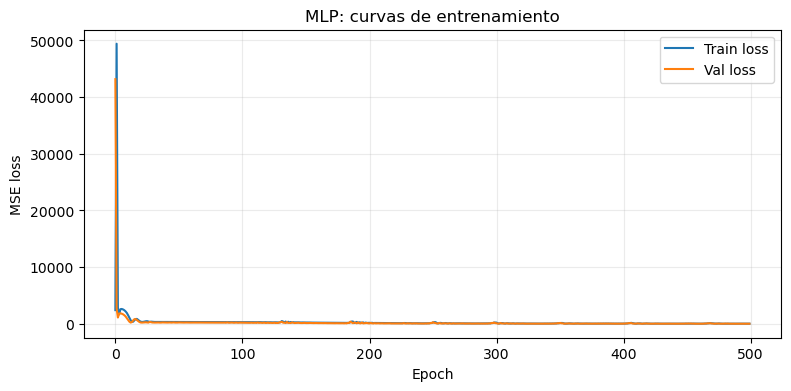

In [73]:
plt.figure(figsize=(9,4))
plt.plot(mlp_hist["train"], label="Train loss")
plt.plot(mlp_hist["val"], label="Val loss")
plt.title("MLP: curvas de entrenamiento")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.grid(True, alpha=0.25)
plt.legend()
plt.show()


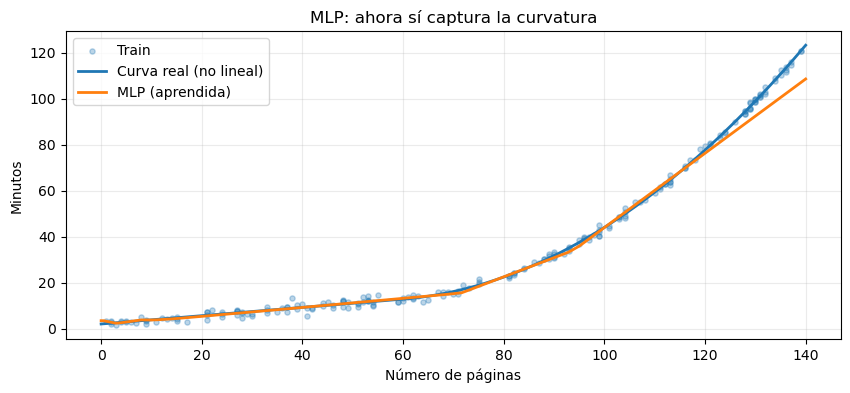

In [74]:
mlp_model.eval()
with torch.no_grad():
    y_mlp = mlp_model(X_line).cpu().numpy().flatten()

plt.figure(figsize=(10,4))
plt.scatter(pages_train, y_train_np, s=14, alpha=0.30, label="Train")
plt.plot(x_grid, y_grid, linewidth=2, label="Curva real (no lineal)")
plt.plot(x_grid, y_mlp, linewidth=2, label="MLP (aprendida)")
plt.title("MLP: ahora sí captura la curvatura")
plt.xlabel("Número de páginas")
plt.ylabel("Minutos")
plt.grid(True, alpha=0.25)
plt.legend()
plt.show()


## Demo: predicciones para tamaños típicos

Probemos con documentos:
- 10 páginas
- 50 páginas
- 80 páginas (zona con penalización)
- 120 páginas (muy grande)

Esperado:
- aumento suave al inicio
- aumento mucho mayor en documentos grandes (no lineal)


In [75]:
test_pages = np.array([10, 50, 80, 120, 150, 200], dtype=np.float32)
X_test = torch.tensor(test_pages).unsqueeze(1).to(device)

mlp_model.eval()
with torch.no_grad():
    pred = mlp_model(X_test).cpu().numpy().flatten()

for p, m in zip(test_pages, pred):
    print(f"{int(p):>3d} páginas  →  {m:>6.2f} minutos estimados")
    print(f"     (valor real: {true_time(p):.2f} minutos)")


 10 páginas  →    3.74 minutos estimados
     (valor real: 3.80 minutos)
 50 páginas  →   11.17 minutos estimados
     (valor real: 11.00 minutos)
 80 páginas  →   22.50 minutos estimados
     (valor real: 22.40 minutos)
120 páginas  →   76.23 minutos estimados
     (valor real: 77.60 minutos)
150 páginas  →  124.67 minutos estimados
     (valor real: 150.50 minutos)
200 páginas  →  205.20 minutos estimados
     (valor real: 332.00 minutos)


# Cierre Parte A

- Una neurona lineal solo aprende líneas: útil cuando el mundo es lineal.
- Cuando aparece complejidad (colas, revisión, I/O), la relación se vuelve curva.
- Un MLP pequeño puede aproximar esa curvatura.

**Puente a SISRED:**
Con texto/documentos, las relaciones suelen ser aún menos lineales.
Por eso el siguiente paso es representar texto y usar redes para clasificación.


# Parte B — Clasificación de documentos (texto) con Redes Neuronales (MLP)

## Contexto SISRED
En SISRED se trabaja con:
- documentos, oficios, solicitudes, tickets
- texto libre (título / resumen / cuerpo)
- necesidad de etiquetar, enrutar y priorizar

## Objetivo
Construir un clasificador que, dado un texto corto, prediga su categoría.

Ejemplos de categorías (ajustables a SISRED):
- Administrativo
- Jurídico/Normativa
- TI/Incidentes
- Transparencia/Acceso


## ¿Por qué una red neuronal aquí?
- Con texto, la relación entre palabras y categorías es **no lineal** y combinatoria.
- Un MLP sobre vectores TF-IDF es un primer modelo neuronal útil:
  - rápido de entrenar
  - fácil de explicar
  - suficiente para un demo realista



In [76]:
import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

def build_sisred_dataset(n_per_class=220):
    # Plantillas realistas (cortas) por categoría
    admin_templates = [
        "Se solicita {accion} para {objeto} y aprobación de {doc}.",
        "Adjunto {doc} para trámite de {accion} y registro en sistema.",
        "Favor gestionar {accion} asociada a {objeto} con prioridad {prio}.",
        "Se requiere coordinación con {area} para completar {doc}."
    ]
    legal_templates = [
        "Se requiere informe jurídico sobre {tema} según {norma}.",
        "Conforme a {norma}, corresponde evaluar {tema} y emitir pronunciamiento.",
        "Solicito revisión normativa respecto a {tema} y posibles implicancias legales.",
        "Preparar minuta legal sobre {tema} en el marco de {norma}."
    ]
    it_templates = [
        "Incidente en {sistema}: error {err} al realizar {accion}. Revisar logs.",
        "Falla en despliegue: {sistema} no responde. Analizar {componente} y rollback si aplica.",
        "Se detecta bug en {componente}: {err}. Requiere hotfix y pruebas.",
        "Solicito mejorar rendimiento de {sistema}: latencia alta en {componente}."
    ]
    transparencia_templates = [
        "Solicitud de acceso a la información: {tema}. Preparar respuesta y respaldo documental.",
        "Se recibe requerimiento de transparencia por {tema}. Gestionar plazos y entrega.",
        "Favor compilar antecedentes para solicitud pública sobre {tema} y derivación a {area}.",
        "Revisión de cumplimiento de plazos de transparencia para caso {tema}."
    ]

    # Vocabulario controlado para variación
    acciones = ["compra", "contratación", "pago", "regularización", "actualización", "revisión", "registro"]
    objetos  = ["insumos", "servicios", "equipamiento", "licencias", "capacitaciones", "proveedores"]
    docs     = ["orden de compra", "memorándum", "solicitud interna", "acta", "resolución", "formulario"]
    prios    = ["alta", "media", "baja"]
    areas    = ["finanzas", "administración", "jurídica", "TI", "sistemas", "archivo"]

    temas    = ["contratos", "licitación", "protección de datos", "propiedad intelectual", "responsabilidad", "acceso a información"]
    normas   = ["Ley de Transparencia", "normativa interna", "ley de compras públicas", "reglamento vigente", "política institucional"]

    sistemas = ["SISRED", "API", "backend", "frontend", "base de datos", "pipeline"]
    errs     = ["500", "timeout", "auth failed", "token inválido", "null reference", "bad gateway"]
    comps    = ["autenticación", "base de datos", "cache", "servidor", "CI/CD", "balanceador"]

    texts = []
    labels = []
    label_names = ["Administrativo", "Jurídico/Normativa", "TI/Incidentes", "Transparencia"]

    def fill(tpl, cls):
        if cls == 0:
            return tpl.format(
                accion=random.choice(acciones),
                objeto=random.choice(objetos),
                doc=random.choice(docs),
                prio=random.choice(prios),
                area=random.choice(areas)
            )
        if cls == 1:
            return tpl.format(
                tema=random.choice(temas),
                norma=random.choice(normas)
            )
        if cls == 2:
            return tpl.format(
                sistema=random.choice(sistemas),
                err=random.choice(errs),
                accion=random.choice(["login", "consulta", "búsqueda", "carga", "exportación"]),
                componente=random.choice(comps)
            )
        if cls == 3:
            return tpl.format(
                tema=random.choice(["gastos", "contratos", "actas", "personal", "proveedores", "presupuesto"]),
                area=random.choice(areas)
            )

    all_templates = [admin_templates, legal_templates, it_templates, transparencia_templates]

    for cls in range(4):
        for _ in range(n_per_class):
            tpl = random.choice(all_templates[cls])
            texts.append(fill(tpl, cls))
            labels.append(cls)

    return texts, np.array(labels, dtype=np.int64), label_names

texts, y, label_names = build_sisred_dataset(n_per_class=220)
len(texts), np.unique(y, return_counts=True)


(880,
 (array([0, 1, 2, 3], dtype=int64), array([220, 220, 220, 220], dtype=int64)))

## Paso 1 — Convertir texto a números (TF-IDF)

Las redes neuronales no procesan texto directamente.
Primero transformamos cada texto a un vector numérico con TF-IDF.

- Cada documento → vector (dimensión = vocabulario)
- Pesos altos para términos importantes del documento


In [77]:
X_train_txt, X_val_txt, y_train_np, y_val_np = train_test_split(
    texts, y, test_size=0.2, random_state=42, stratify=y
)

vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2)
)

X_train = vectorizer.fit_transform(X_train_txt).toarray().astype(np.float32)
X_val   = vectorizer.transform(X_val_txt).toarray().astype(np.float32)

# Tensores
X_train_t = torch.tensor(X_train).to(device)
y_train_t = torch.tensor(y_train_np).to(device)

X_val_t = torch.tensor(X_val).to(device)
y_val_t = torch.tensor(y_val_np).to(device)

X_train_t.shape, y_train_t.shape


(torch.Size([704, 559]), torch.Size([704]))

## Paso 2 — Definir el clasificador neuronal (MLP)

Arquitectura simple y efectiva:
- Linear → ReLU → Dropout
- Linear → ReLU → Dropout
- Linear → (logits de 4 clases)

Usamos **CrossEntropyLoss**, que internamente aplica softmax.


In [78]:
class TextMLP(nn.Module):
    def __init__(self, input_dim, num_classes=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

model_b = TextMLP(input_dim=X_train_t.shape[1], num_classes=len(label_names)).to(device)
criterion_b = nn.CrossEntropyLoss()
optimizer_b = optim.Adam(model_b.parameters(), lr=0.003)

model_b


TextMLP(
  (net): Sequential(
    (0): Linear(in_features=559, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=4, bias=True)
  )
)

## Paso 3 — Entrenar (rápido)

Entrenaremos pocas épocas (8–12) para que calce en la clase.
En cada época medimos:
- loss en train
- loss y accuracy en validation


In [79]:
def accuracy_from_logits(logits, y_true):
    preds = torch.argmax(logits, dim=1)
    return (preds == y_true).float().mean().item()

epochs = 10
batch_size = 64

train_hist = {"train_loss": [], "val_loss": [], "val_acc": []}

# mini dataloader manual
num_train = X_train_t.shape[0]
perm_idx = torch.arange(num_train)

for epoch in range(1, epochs+1):
    model_b.train()
    # shuffle
    perm = torch.randperm(num_train, device=device)
    X_shuf = X_train_t[perm]
    y_shuf = y_train_t[perm]

    # batches
    epoch_loss = 0.0
    for i in range(0, num_train, batch_size):
        xb = X_shuf[i:i+batch_size]
        yb = y_shuf[i:i+batch_size]

        optimizer_b.zero_grad()
        logits = model_b(xb)
        loss = criterion_b(logits, yb)
        loss.backward()
        optimizer_b.step()

        epoch_loss += loss.item() * xb.size(0)

    train_loss = epoch_loss / num_train

    # validation
    model_b.eval()
    with torch.no_grad():
        val_logits = model_b(X_val_t)
        val_loss = criterion_b(val_logits, y_val_t).item()
        val_acc = accuracy_from_logits(val_logits, y_val_t)

    train_hist["train_loss"].append(train_loss)
    train_hist["val_loss"].append(val_loss)
    train_hist["val_acc"].append(val_acc)

    print(f"Epoch {epoch:02d} | train_loss {train_loss:.3f} | val_loss {val_loss:.3f} | val_acc {val_acc:.3f}")


Epoch 01 | train_loss 1.247 | val_loss 0.862 | val_acc 1.000
Epoch 02 | train_loss 0.363 | val_loss 0.012 | val_acc 1.000
Epoch 03 | train_loss 0.004 | val_loss 0.000 | val_acc 1.000
Epoch 04 | train_loss 0.000 | val_loss 0.000 | val_acc 1.000
Epoch 05 | train_loss 0.000 | val_loss 0.000 | val_acc 1.000
Epoch 06 | train_loss 0.000 | val_loss 0.000 | val_acc 1.000
Epoch 07 | train_loss 0.000 | val_loss 0.000 | val_acc 1.000
Epoch 08 | train_loss 0.000 | val_loss 0.000 | val_acc 1.000
Epoch 09 | train_loss 0.000 | val_loss 0.000 | val_acc 1.000
Epoch 10 | train_loss 0.000 | val_loss 0.000 | val_acc 1.000


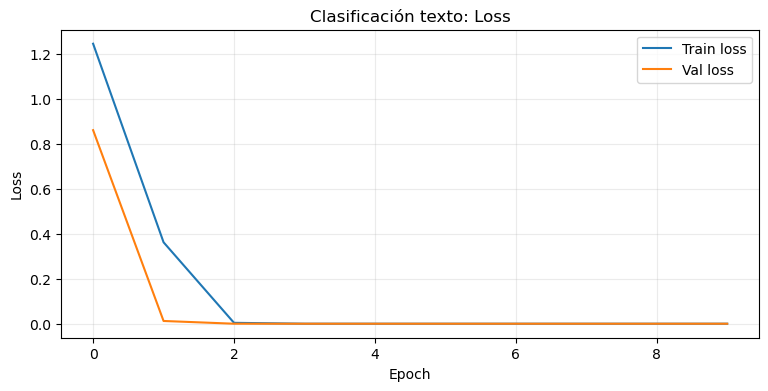

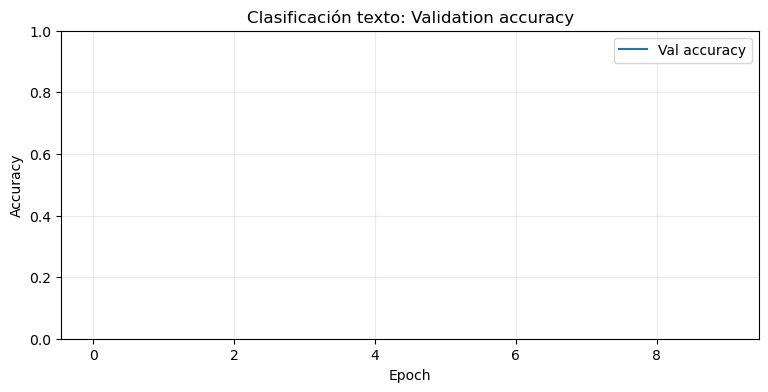

In [80]:
plt.figure(figsize=(9,4))
plt.plot(train_hist["train_loss"], label="Train loss")
plt.plot(train_hist["val_loss"], label="Val loss")
plt.title("Clasificación texto: Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.25)
plt.legend()
plt.show()

plt.figure(figsize=(9,4))
plt.plot(train_hist["val_acc"], label="Val accuracy")
plt.title("Clasificación texto: Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
plt.grid(True, alpha=0.25)
plt.legend()
plt.show()


## Paso 4 — Evaluación: matriz de confusión + métricas

Esto es lo que más importa en práctica:
- ¿qué clases confunde?
- ¿dónde falla?

En SISRED, ciertos errores pueden costar más (p.ej. legal mal derivado).


In [81]:
def predict_text_proba(text):
    x = vectorizer.transform([text]).toarray().astype(np.float32)
    x_t = torch.tensor(x).to(device)

    model_b.eval()
    with torch.no_grad():
        logits = model_b(x_t)
        probs = torch.softmax(logits, dim=1).cpu().numpy().flatten()

    order = np.argsort(-probs)
    return [(label_names[i], float(probs[i])) for i in order]

examples = [
    "Se solicita informe jurídico conforme a la Ley de Transparencia para contratos y proveedores.",
    "Incidente en SISRED: error 500 al realizar búsqueda. Revisar logs del backend y autenticación.",
    "Favor gestionar orden de compra para insumos y adjuntar memorándum para aprobación.",
    "Requerimiento de acceso a la información pública: presupuesto y gastos del último trimestre."
]

for t in examples:
    preds = predict_text_proba(t)
    print("\nTexto:", t)
    for cls, p in preds[:3]:
        print(f"  - {cls:>20s}: {p:.3f}")



Texto: Se solicita informe jurídico conforme a la Ley de Transparencia para contratos y proveedores.
  -   Jurídico/Normativa: 0.970
  -       Administrativo: 0.021
  -        Transparencia: 0.009

Texto: Incidente en SISRED: error 500 al realizar búsqueda. Revisar logs del backend y autenticación.
  -        TI/Incidentes: 1.000
  -        Transparencia: 0.000
  -       Administrativo: 0.000

Texto: Favor gestionar orden de compra para insumos y adjuntar memorándum para aprobación.
  -       Administrativo: 1.000
  -   Jurídico/Normativa: 0.000
  -        Transparencia: 0.000

Texto: Requerimiento de acceso a la información pública: presupuesto y gastos del último trimestre.
  -        Transparencia: 1.000
  -        TI/Incidentes: 0.000
  -       Administrativo: 0.000
